In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from typing import Dict, List, Any
from jsonlines import jsonlines
from itertools import islice
from math import ceil
from tqdm.notebook import tqdm

from src.settings import PREPROCESSED_DIR

In [2]:
class ClipsDataset(Dataset):

    def __init__(self, records: List[Dict[str, Any]]):
        self.records = records
        self.lstm = nn.LSTM(99, 99, batch_first=False)

    def __len__(self) -> int:
        return len(self.records)
    
    def get_frame_seq_landmarks_spatial_features(self, flatten_frame_seq_landmarks: List[List[int]]) -> np.ndarray:
        # frame_seq_landmarks ( n_frames x n_landmarks x 3 )
        # spatial_features ( n_landmarks x 3 )
        lstm_output, (hn, cn) = self.lstm(flatten_frame_seq_landmarks)
        return hn[-1].detach()

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        out_polish_token_ids = torch.tensor(self.records[index]["PolishAnnotationTokenIds"], dtype=torch.int32)
        flatten_frame_seq_landmarks = torch.tensor(self.records[index]["FramesLandmarksCoords"], dtype=torch.float32).view(-1, 99)
        frame_seq_landmarks_spatial_features = self.get_frame_seq_landmarks_spatial_features(flatten_frame_seq_landmarks)
        print(frame_seq_landmarks_spatial_features.shape)
        if len(out_polish_token_ids) > 66:
            print("Warning: PolishAnnotationTokenIds is longer than 66")
            out_polish_token_ids = out_polish_token_ids[:66]
        return {
            # "in_landmarks": flatten_landmarks,
            "in_landmarks": frame_seq_landmarks_spatial_features,
            "out_polish_token_ids": out_polish_token_ids,
        }

In [3]:
with jsonlines.open(PREPROCESSED_DIR / "clips_dataset_wth_herbert_token_ids.jsonl") as reader:
    raw_records = list(islice(reader, 20))
    # raw_records = list(reader)
    clips_dataset = ClipsDataset(records=raw_records)

In [4]:
train_ds, val_ds = train_test_split(clips_dataset, test_size=0.2, random_state=42)

len(train_ds), len(val_ds)

torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])
torch.Size([99])


(16, 4)

In [5]:
pd.Series([record["NumFrames"] for record in raw_records]).describe()

count     20.000000
mean      99.450000
std      108.674538
min       12.000000
25%       22.000000
50%       52.500000
75%      131.000000
max      392.000000
dtype: float64

In [6]:
pd.Series([record["PolishAnnotationTokenIds"] for record in raw_records]).map(len).describe()

count    20.0
mean     66.0
std       0.0
min      66.0
25%      66.0
50%      66.0
75%      66.0
max      66.0
dtype: float64

In [7]:
for record in train_ds:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks x 3
    print(record["out_polish_token_ids"].shape)  # 1 x padded n_tokens
    break

torch.Size([99])
torch.Size([66])


In [8]:
N_LANDMARKS = 33
COORD_CHANNELS = 3
MAX_TOKENS = 66
MAX_FRAMES = 392

In [9]:
class LandmarksTranslator(nn.Module):
    
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.lstm = nn.LSTM(input_dim, output_dim, batch_first=True)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x = x.view(-1, self.input_dim)

        output, (hn, cn) = self.lstm(x)
        # print(output.shape)
        x = output

        # print(x)
        # print(output.shape, hn.shape, cn.shape)
        # x = self.linear(x)

        # try get `token_ids` imitation
        min_id, max_id = 0, 25_000
        min_x_val = x.min(axis=0).values
        max_x_val = x.max(axis=0).values
        # print(min_x_val, max_x_val)
        
        x = (x - min_x_val) / (max_x_val - min_x_val)  # normalize to [0, 1]
        x = (x  * (max_id - min_id)) + min_id  # scale to [min_id, max_id]

        return x

In [10]:
class LandmarksTranslatorT5(nn.Module):

    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.t5 = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        # x: (batch_size x seq_len x vec_size)
        x = self.t5.forward(inputs_embeds=x, output_hidden_states=True)

        # # try get `token_ids` imitation
        # min_id, max_id = 0, 25_000
        # min_x_val = x.min(axis=0).values
        # max_x_val = x.max(axis=0).values
        # # print(min_x_val, max_x_val)
        
        # x = (x - min_x_val) / (max_x_val - min_x_val)  # normalize to [0, 1]
        # x = (x  * (max_id - min_id)) + min_id  # scale to [min_id, max_id]

        return x

In [11]:
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device="cuda"):
    herbert_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
    model_name = model.__class__.__name__
    metrics_history = []
    for epoch in tqdm(range(epochs), desc="Epochs: ", leave=True, position=0):
        last_epoch = epoch == epochs - 1
        train_losses = []
        val_losses = []
        val_accs = []
        # for n_batch, batch in enumerate(tqdm(train_dl, desc="Batches: ", leave=False, position=1)):
        for n_batch, batch in enumerate(train_dl):
            X_batch = batch["in_landmarks"].to(device)
            y_batch = batch["out_polish_token_ids"].to(device)
            # print(y_batch.shape)

            y_pred = model(X_batch)
            # print(y_pred.shape)

            first_batch = n_batch == 0
            if first_batch and (epoch % ceil(epochs * 0.1) == 0 or last_epoch):
                decoded_y_batch = herbert_tokenizer.decode(y_batch[0], skip_special_tokens=True)
                decoded_y_pred_batch = herbert_tokenizer.decode(y_pred[0].int(), skip_special_tokens=True)
                print(f"{decoded_y_batch=}")
                print(f"{decoded_y_pred_batch=}")
                # for decoded_y, decoded_y_pred in zip(decoded_y_batch, decoded_y_pred_batch):
                #     print(f"{decoded_y=}")
                #     print(f"{decoded_y_pred=}")
                #     print()
                print("-".center(80, "-"))

            if y_pred.shape != y_batch.shape:
                print(f"{y_pred.shape=}, {y_batch.shape=} mismatched!")
                continue
                
            loss = loss_fn(y_pred, y_batch.float())

            optimizer.zero_grad()
            loss.backward()  # backward pass, calculate gradients
            optimizer.step()  # update weights

            # val_loss, val_acc = validate(model, val_dl, loss_fn, device=device)
            val_loss = validate(model, val_dl, loss_fn, device=device)
            
            train_losses.append(loss.item())
            val_losses.append(val_loss)
            # val_accs.append(val_acc)

        epoch_metrics = {
            "Epoch": epoch + 1,
            "ModelName": model_name,
            "TrainLoss": np.mean(train_losses),
            "ValLoss": np.mean(val_losses),
            # "ValAcc": np.mean(val_accs)
        }
        metrics_history.append(epoch_metrics)

        if epoch % ceil(epochs * 0.1) == 0 or last_epoch:
            print(
                f"Epoch: {epoch + 1:<2} | "
                + " ".join([f"{k}: {v:.6f}" for k, v in list(epoch_metrics.items())[2:]])
            )

    return metrics_history


def validate(model, val_dl, loss_fn, device="cuda"):
    losses = []
    accuracies = []
    for batch in val_dl:
        X_batch = batch["in_landmarks"].to(device)
        y_batch = batch["out_polish_token_ids"].to(device)

        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch.float())
        losses.append(loss.item())
        
        # acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).cpu().float().mean()
        # accuracies.append(acc)

    # return np.mean(losses), np.mean(accuracies)
    return np.mean(losses)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "\n")


BATCH_SIZE = 4
EPOCHS = 100
LEARING_RATE = 0.001


assert BATCH_SIZE <= len(train_ds) and BATCH_SIZE <= len(val_ds)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

model = LandmarksTranslator(
# model = LandmarksTranslatorT5(
    input_dim=N_LANDMARKS*COORD_CHANNELS,
    output_dim=MAX_TOKENS
).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARING_RATE)
loss_fn = nn.CrossEntropyLoss()

metrics_history = train(model, train_dl, val_dl, optimizer, loss_fn, epochs=EPOCHS, device=device)

Device: cuda 



Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

decoded_y_batch='Aha.'
decoded_y_pred_batch='KrowodKrowodbulKrowodKrowodKrowodKrowodKrowodKrowodTEKrowodKrowodwom KrowodKrowodubiegKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowod'
--------------------------------------------------------------------------------
Epoch: 1  | TrainLoss: 1009100176.000000 ValLoss: 1766674496.000000
decoded_y_batch='Przyczepa ok, łyżwy ok, ale hulajnoga? Nie da się przewrócić do przodu.'
decoded_y_pred_batch='KrowodżonaKrowodczyc mieniem KrowodKrowodKrowodKrowodKrowodpowinieKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodKrowodutoKrowodKOWpochKrowodKrowodKrowodpotencjalzobacz KrowodKrowodKrowodKrowod'
--------------------------------------------------------------------------------
Epoch: 11 | TrainLoss: 848256764.000000 ValLoss: 1311674272.000000
decoded_y_batch='Tak.'
decoded_y_pred_batch='KrowodleaKrowodnałopodpisyadresem KrowodKrowodKrowodKrowodKrowodknie nianych Inna KrowodKrowodtropiKrowodKrowodKrowodKrowodKrow

In [13]:
metrics_history_df = pd.DataFrame.from_records(metrics_history)
metrics_history_df

,Epoch,ModelName,TrainLoss,ValLoss
0,1,LandmarksTranslator,1.009100e+09,1.766674e+09
1,2,LandmarksTranslator,1.036425e+09,1.440848e+09
2,3,LandmarksTranslator,1.050418e+09,1.407329e+09
3,4,LandmarksTranslator,1.043948e+09,1.647783e+09
4,5,LandmarksTranslator,8.445290e+08,1.527419e+09
...,...,...,...,...
95,96,LandmarksTranslator,4.343191e+08,1.276665e+09
96,97,LandmarksTranslator,6.092524e+08,1.450343e+09
97,98,LandmarksTranslator,4.842765e+08,9.903058e+08
98,99,LandmarksTranslator,6.316320e+08,1.259055e+09


<Axes: >

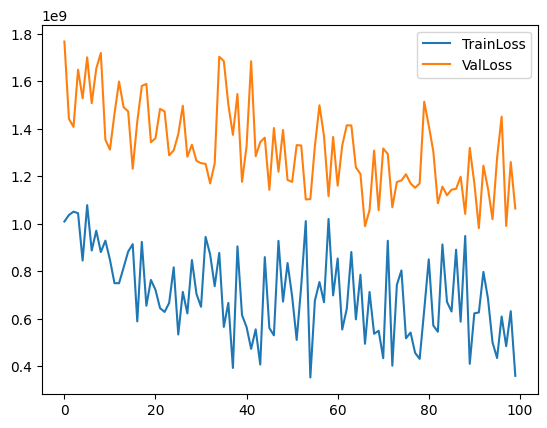

In [14]:
metrics_history_df[["TrainLoss", "ValLoss"]].plot()